In [1]:
import lpr
import fpca
###lpr
import numpy as np
import scipy as sp
from scipy import signal
import arrayfire as af
from numba import jit
###fpca
from scipy import interpolate
import random

###simulation
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time

import pandas as pd
from sklearn import datasets
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# 4.2 simulation-1-dense

# Uij=Xi(Tij)+epsilon

In [2]:
def EigF1(t):
    return(np.cos(np.pi * t/10) /np.sqrt(5))

def EigF2(t):
    return(np.sin(np.pi * t/10) /np.sqrt(5))

def XMeanF(t):
    return(t+np.sin(t))

def CovF(s, t):
    return(eig_val[0] * EigF1(s) * EigF1(t) + eig_val[1] * EigF2(s) * EigF2(t))

In [3]:
eig_val = np.array([2, 1])
sigma2 = 0.1
num_grid = 500
num_fun = 100
num_pt = num_grid
d = 1

t1 = np.linspace(0, 10, num_grid)
t_grid = t1

In [5]:
real_mean = XMeanF(t_grid)
real_cov = CovF(t_grid.repeat(num_grid), np.tile(t_grid, num_grid)).reshape(num_grid**2, -1)
real_cov_dia = np.diag(real_cov)
real_eigfun1 = EigF1(t_grid)
real_eigfun2 = EigF2(t_grid)

In [6]:
np.random.seed(501)
#501

t_of_fun = t1.repeat(num_fun).reshape(-1, num_fun).T
# print(t_of_fun)

pc_score = np.array((np.random.normal(0, np.sqrt(eig_val[0]), num_fun),
                  np.random.normal(0, np.sqrt(eig_val[1]), num_fun))).reshape(2, num_fun).T
#print(pc_score )

epsilon = np.array(np.random.normal(0, np.sqrt(sigma2), (num_fun, num_pt)))
#print(epsilon)

eigf1 = EigF1(t_of_fun).reshape(num_fun, num_pt)
eigf2 = EigF2(t_of_fun).reshape(num_fun, num_pt)
meanf = XMeanF(t_of_fun).reshape(num_fun, num_pt)
eigf = np.array([eigf1, eigf2])

xi = np.zeros_like(eigf1)
for n_f in range(num_fun):
    xi[n_f] = meanf.take(n_f, 0) + pc_score.take(n_f, 0).dot(eigf.take(n_f, 1))

u = xi + epsilon
# print(u)
# print(np.shape(u))

In [7]:
candidate_h_mean = np.arange(0.55, 5, 0.3).reshape(-1, d)
candidate_h_cov = np.arange(0.55, 5, 0.3).repeat(2).reshape(-1, 2 * d)
candidate_h_diag_cov = np.arange(0.55, 5, 0.3).reshape(-1, d)

In [346]:
fpca.lpr.Set_arrayfire_backend('cpu')
#fpca.lpr.Set_arrayfire_backend('opencl')
#fpca.lpr.Set_arrayfire_backend('cuda')

In [347]:
pre_time = time.time()
Xresult = fpca.Fpca(x = list(t_of_fun.reshape(num_fun, num_pt, d)),
                   y = list(u.reshape(num_fun, num_pt)),
                   x0 = t_grid.reshape(num_grid, d), 
                   h_mean = candidate_h_mean,
                   h_cov = candidate_h_cov,
                   h_cov_dia = candidate_h_diag_cov,
                   bin_weight = False,
                   fve = 0.85,
                   bw_select = 'Partition',
#                   bw_select = 'LeaveOneOut',                    
                   dtype = 'f4')
time.time() - pre_time

25.769123792648315

In [348]:
print(Xresult)

Number of grid: 500
Number of random function: 100
Eigen pairs: 2
Sigma2: 0.202387
Bandwidth of mean: [0.55]
Bandwidth of cov: [0.55, 0.55]
Bandwidth of cov_diag: [0.55]


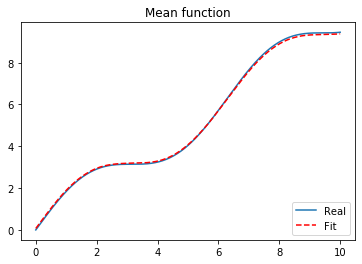

In [349]:
fig1 = plt.figure(1)
plt.plot(t1, real_mean, label = 'Real')
plt.plot(t1, Xresult.mean_fun, '--r', label = 'Fit')
plt.legend(loc = 4)
plt.title('Mean function')

plt.show()

In [350]:
# print(Xresult.mean_fun)
# print(np.shape(Xresult.mean_fun))
# print(Xresult.cov_fun)
# print(np.shape(Xresult.cov_fun))


# print(Xresult.cov_dia)
# print(np.shape(Xresult.ccov_dia))

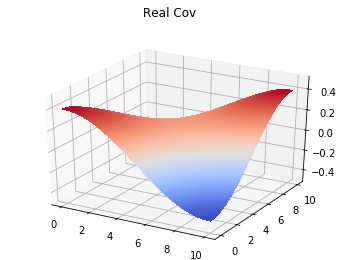

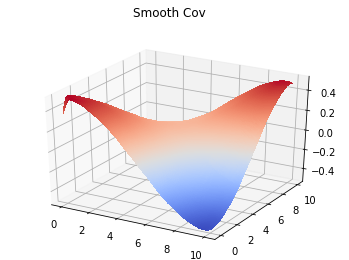

In [351]:
fig1 = plt.figure(1)
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(t1.repeat(t1.size).reshape(num_grid, num_grid), 
                       np.tile(t1, t1.size).reshape(num_grid, num_grid), 
                       real_cov.reshape(num_grid, num_grid),
                       rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0.1, antialiased=False)
ax.set_zlim3d(-0.5, 0.5)
plt.suptitle('Real Cov')

fig2 = plt.figure(2)
ax = fig2.gca(projection='3d')
surf = ax.plot_surface(t1.repeat(t1.size).reshape(num_grid, num_grid), 
                       np.tile(t1, t1.size).reshape(num_grid, num_grid), 
                       Xresult.cov_fun,
                       rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0.1, antialiased=False)

plt.suptitle('Smooth Cov')
plt.show()

Real eigen values: 2, 1
Fitted eigen values: 2.54121, 0.84426


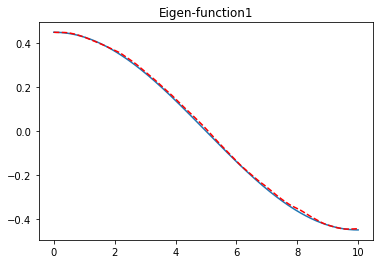

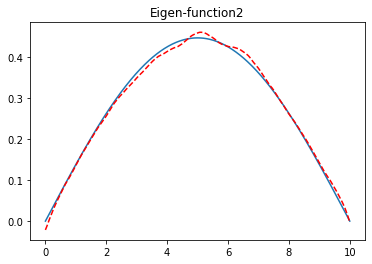

In [309]:
print("Real eigen values: %s" %", ".join(map(str, eig_val)))
print("Fitted eigen values: %s" %", ".join(map(str, np.round(Xresult.eig_val[0:2], 5))))

fig1 = plt.figure(1)
plt.plot(t1, real_eigfun1)
direction1 = 1 if (real_eigfun1.dot(Xresult.eig_fun[0]) > 0) else -1
plt.plot(t1, direction1 * Xresult.eig_fun[0], '--r')
plt.title('Eigen-function1')

fig2 = plt.figure(2)
plt.plot(t1, real_eigfun2)
direction2 = 1 if (real_eigfun2.dot(Xresult.eig_fun[1]) > 0) else -1
plt.plot(t1, direction2 * Xresult.eig_fun[1], '--r')
plt.title('Eigen-function2')

plt.show()

In [310]:
print("Real eigen values: %s" %", ".join(map(str, eig_val)))
print("Fitted eigen values of Xresult: %s" %", ".join(map(str, Xresult.eig_val[0:2])))

Real eigen values: 2, 1
Fitted eigen values of Xresult: 2.5412054, 0.8442582


In [311]:
print('Estimate fpc scores by PACE')
mse_pc = np.mean((pc_score - Xresult.fpc_scores[:, 0:2] * np.array([direction1, direction2]))**2, axis = 0)
print('MSE of fpc_scores: %s' %", ".join(map(str, mse_pc)))

Estimate fpc scores by PACE
MSE of fpc_scores: 0.03142574023147516, 0.003606129003805947


In [312]:
print("Real Sigma2: %f" %sigma2)
print("Fitted Sigma2: %f" %Xresult.sigma2)

Real Sigma2: 0.100000
Fitted Sigma2: 0.202144


# test

In [313]:
restruct_pc_score, fit_x1_to_x4 = Xresult.Restruct_Fun(list(t_of_fun.reshape(num_fun, num_pt, d).take(np.arange(4), 0)), 
                                                      list(u.reshape(num_fun, num_pt).take(np.arange(4), 0)))

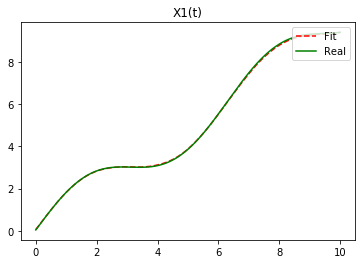

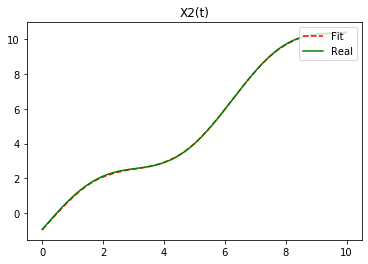

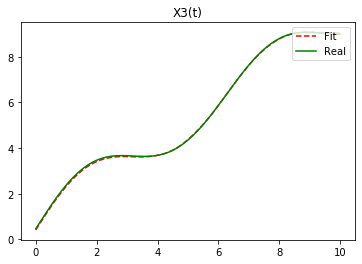

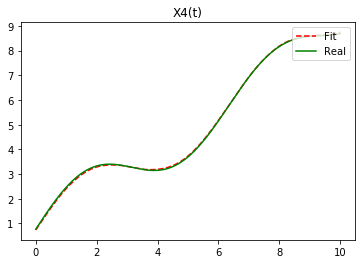

In [314]:
for i in range(4):
    fig = plt.figure(i)
    sort_order = np.argsort(t_of_fun[i])
    plt.plot(t1, fit_x1_to_x4[i], '--r', label = 'Fit')
    plt.plot(t1, real_mean + pc_score.take(i, 0).dot(np.asarray([real_eigfun1, real_eigfun2])), 'green', label = 'Real')
    plt.legend(loc = 1)
    plt.title('X' + str(i + 1) + '(t)')
plt.show()

In [315]:
dt = 1 / (num_grid - 1)

ISE = np.zeros(num_fun)
fit_x = Xresult.Restruct_Fun(t_of_fun.reshape(num_fun, num_pt, d), u.reshape(num_fun, num_pt))[1]

for i in range(num_fun):
    sort_order = np.argsort(t_of_fun[i])
    ISE[i] = np.sum((fit_x.take(i, 0) - (real_mean + pc_score.take(i, 0).dot(np.asarray([real_eigfun1, real_eigfun2]))))**2) * dt

MISE = ISE.mean()
print(MISE)

0.0009279813927616038


# Vij=Yi(Tij)+epsilon

In [264]:
#y
def YMeanF(t):
    return(t+np.sin(np.pi * t/10)*(t+np.sin(t)))
def beta0(t):
    return(t)
def beta1(t):
    return(np.sin(np.pi * t/10))

In [316]:
#eig_val = np.array([2,1])
sigma2 = 0.1
num_grid = 500
num_fun = 100
num_pt = num_grid
d = 1

t1 = np.linspace(0, 10, num_grid)
t_grid = t1

In [317]:
real_mean = YMeanF(t_grid)
real_cov =np.sin((np.pi) * (t_grid.repeat(num_grid))/10).reshape(num_grid**2, -1)*np.sin((np.pi )* (np.tile(t_grid, num_grid))/10).reshape(num_grid**2, -1)* CovF(t_grid.repeat(num_grid), np.tile(t_grid, num_grid)).reshape(num_grid**2, -1)
real_cov_dia = np.diag(real_cov)
# real_eigfun1 = EigF1(t_grid)
# real_eigfun2 = EigF2(t_grid)

In [318]:
np.random.seed(501)

t_of_fun = t1.repeat(num_fun).reshape(-1, num_fun).T
#print(t_of_fun)

epsilon = np.array(np.random.normal(0, np.sqrt(sigma2), (num_fun, num_pt)))

v= beta0(t_grid)+xi*beta1(t_grid)+epsilon
# print(v)
# print(np.shape(v))

In [319]:
print(np.shape(t_of_fun))
print(np.shape(xi))
print(np.shape(v))

(100, 400)
(100, 400)
(100, 400)


In [320]:
candidate_h_mean = np.arange(0.2 , 4 , 0.3).reshape(-1, d)
candidate_h_cov = np.arange(0.2 ,  4 , 0.3).repeat(2).reshape(-1, 2 * d)
candidate_h_diag_cov = np.arange(0.2 , 4 , 0.3).reshape(-1, d)
#0.2,4,0.3
#0.2,4,0.8
#0.2,4,0.9
#0.2,4,0.95
#0.2,4,1

In [321]:
fpca.lpr.Set_arrayfire_backend('cpu')
#fpca.lpr.Set_arrayfire_backend('opencl')
#fpca.lpr.Set_arrayfire_backend('cuda')

In [322]:
pre_time = time.time()
Yresult = fpca.Fpca(x = list(t_of_fun.reshape(num_fun, num_pt, d)),
                   y = list(v.reshape(num_fun, num_pt)),
                   x0 = t_grid.reshape(num_grid, d), 
                   h_mean = candidate_h_mean,
                   h_cov = candidate_h_cov,
                   h_cov_dia = candidate_h_diag_cov,
                   bin_weight = False,
                   fve = 0.85,
#                   bw_select = 'Partition',
                   bw_select = 'LeaveOneOut',
                   dtype = 'f4')
time.time() - pre_time

552.1525235176086

In [323]:
print(Yresult)

Number of grid: 400
Number of random function: 100
Eigen pairs: 2
Sigma2: 0.126521
Bandwidth of mean: [0.2]
Bandwidth of cov: [0.2, 0.2]
Bandwidth of cov_diag: [0.2]


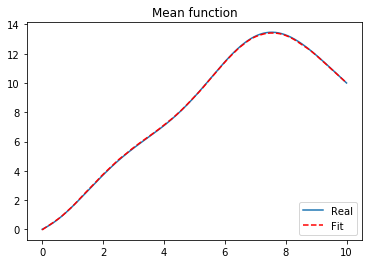

In [324]:
fig1 = plt.figure(1)
plt.plot(t1, real_mean, label = 'Real')
plt.plot(t1, Yresult.mean_fun, '--r', label = 'Fit')
plt.legend(loc = 4)
plt.title('Mean function')

plt.show()

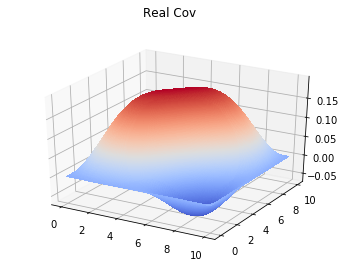

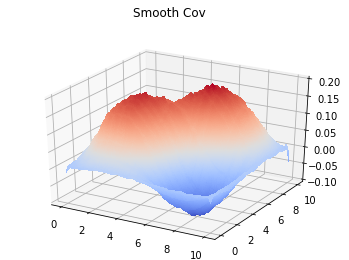

In [325]:
fig1 = plt.figure(1)
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(t1.repeat(t1.size).reshape(num_grid, num_grid), 
                       np.tile(t1, t1.size).reshape(num_grid, num_grid), 
                       real_cov.reshape(num_grid, num_grid),
                       rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0.1, antialiased=False)
plt.suptitle('Real Cov')

fig2 = plt.figure(2)
ax = fig2.gca(projection='3d')
surf = ax.plot_surface(t1.repeat(t1.size).reshape(num_grid, num_grid), 
                       np.tile(t1, t1.size).reshape(num_grid, num_grid), 
                       Yresult.cov_fun,
                       rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0.1, antialiased=False)
ax.set_zlim3d(-0.1, 0.2)

plt.suptitle('Smooth Cov')
plt.show()

In [15]:
t1 = np.linspace(0, 10, num_grid)
t_grid = t1
print(np.shape(t1.repeat(t1.size).reshape(num_grid, num_grid)))
print(np.shape(np.tile(t1, t1.size).reshape(num_grid, num_grid)))
print(t1.repeat(t1.size).reshape(num_grid, num_grid))
print(np.tile(t1, t1.size).reshape(num_grid, num_grid))

(500, 500)
(500, 500)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.02004008  0.02004008  0.02004008 ...  0.02004008  0.02004008
   0.02004008]
 [ 0.04008016  0.04008016  0.04008016 ...  0.04008016  0.04008016
   0.04008016]
 ...
 [ 9.95991984  9.95991984  9.95991984 ...  9.95991984  9.95991984
   9.95991984]
 [ 9.97995992  9.97995992  9.97995992 ...  9.97995992  9.97995992
   9.97995992]
 [10.         10.         10.         ... 10.         10.
  10.        ]]
[[ 0.          0.02004008  0.04008016 ...  9.95991984  9.97995992
  10.        ]
 [ 0.          0.02004008  0.04008016 ...  9.95991984  9.97995992
  10.        ]
 [ 0.          0.02004008  0.04008016 ...  9.95991984  9.97995992
  10.        ]
 ...
 [ 0.          0.02004008  0.04008016 ...  9.95991984  9.97995992
  10.        ]
 [ 0.          0.02004008  0.04008016 ...  9.95991984  9.97995992
  10.        ]
 [ 0.          0.02004008  0.04008016 ...  9.95991984  9.97995992
  10.        ]]


# Estimate G_xx and G_xy

In [326]:
G_xx=Xresult.cov_fun
# print(G_xx)
print(np.shape(G_xx))

(400, 400)


In [328]:
G_xxt=np.zeros(500)
for i in range(0,500):
    G_xxt[i]=G_xx[i][i]
# print(G_xxt)
print(np.shape(G_xxt))

(400,)


In [329]:
Xhat=Xresult.Restruct_Fun(t_of_fun.reshape(num_fun, num_pt, d), u.reshape(num_fun, num_pt))[1]
Yhat=Yresult.Restruct_Fun(t_of_fun.reshape(num_fun, num_pt, d), v.reshape(num_fun, num_pt))[1]
Xbar=Xresult.mean_fun
Ybar=Yresult.mean_fun
# restruct_pc_score, fit_x1_to_x4 = Xresult.Restruct_Fun
#                                                                     (list(t_of_fun.reshape(num_fun, num_pt, d).take(np.arange(4), 0)),
#                                                                      list(u.reshape(num_fun, num_pt).take(np.arange(4), 0)))
#XXhat=Xresult.Restruct_Fun(list(t_of_fun.reshape(num_fun, num_pt, d).take(np.arange(100), 0)),list(u.reshape(num_fun, num_pt).take(np.arange(100), 0)))

In [330]:
print('Xhat')
#print(Xhat)
print(np.shape(Xhat))
print('Yhat')
#print(Yhat)
print(np.shape(Yhat))
print('Xbar')
#print(Xbar)
print(np.shape(Xbar))
print('Ybar')
#print(Ybar)
print(np.shape(Ybar))

Xhat
(100, 400)
Yhat
(100, 400)
Xbar
(400,)
Ybar
(400,)


In [331]:
G_xy=0
for i in range (0,100):
    G_xyi=(Xhat[i]-Xbar)*(Yhat[i]-Ybar)
    G_xy=G_xy+G_xyi
G_xy=G_xy/99
#print(G_xy)
print(np.shape(G_xy))

(400,)


# Estimate B_0 B_1

In [332]:
B_1=G_xy/G_xxt
B_0=Yresult.mean_fun-B_1*Xresult.mean_fun

In [333]:
print('B_1')
#print(B_1)
print(np.shape(B_1))
print('B_0')
#print(B_0)
print(np.shape(B_0))

B_1
(400,)
B_0
(400,)


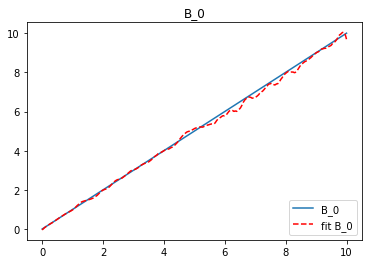

In [334]:
#B_0
fig1 = plt.figure(1)
x = np.linspace(0, 10, num_grid)
y = x
plt.plot(x,y, label = 'B_0')
plt.plot(t1, B_0, '--r', label = 'fit B_0')
plt.legend(loc = 4)
plt.title('B_0')

plt.show()

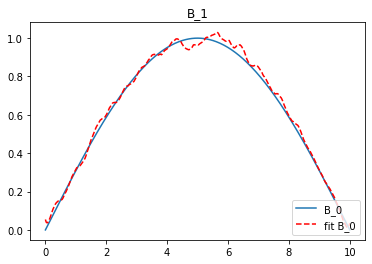

In [335]:
#B_1
fig1 = plt.figure(1)
x = np.linspace(0, 10, num_grid)
y = np.sin(np.pi*x/10)
plt.plot(x,y, label = 'B_0')
plt.plot(t1, B_1, '--r', label = 'fit B_0')
plt.legend(loc = 4)
plt.title('B_1')

plt.show()

# MADE

In [336]:
tt=np.linspace(0, 10, num_grid)
TB_0=np.linspace(0, 10, num_grid)
TB_1=np.sin(np.pi*tt/10)

In [338]:
MADE0=0
MADE1=0
for i in range(0,400):
    MADE0i=np.abs(TB_0[i]-B_0[i])
    MADE1i=np.abs(TB_1[i]-B_1[i])
    MADE0=MADE0+MADE0i
    MADE1=MADE1+MADE1i
    
MADE=(MADE0/10+MADE1)/20
print("MADE: %f" %MADE)

MADE: 0.561953


# WASE

In [339]:
WASE0=0
WASE1=0
for i in range(0,400):
    WASE0i=np.square(TB_0[i]-B_0[i])
    WASE1i=np.square(TB_1[i]-B_1[i])
    WASE0=WASE0+WASE0i
    WASE1=WASE1+WASE1i
    
WASE=(WASE0/100+WASE1)/20
print("WASE: %f" %WASE)

WASE: 0.014120


# UASE

In [340]:
UASE0=0
UASE1=0
for i in range(0,500):
    UASE0i=np.square(TB_0[i]-B_0[i])
    UASE1i=np.square(TB_1[i]-B_1[i])
    UASE0=UASE0+UASE0i
    UASE1=UASE1+UASE1i
    
UASE=(UASE0+UASE1)/20
print("UASE: %f" %UASE)

UASE: 0.354146
